<a href="https://colab.research.google.com/github/jinglescode/time-series-forecasting-pytorch/blob/main/demo-predicting-stock-prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import tensorflow as tf
from tensorflow import keras
import sys
tf.__version__
keras.__version__


'2.9.0'

# Predicting Stock Prices with Deep Neural Networks

This project walks you through the end-to-end data science lifecycle of developing a predictive model for stock price movements with Alpha Vantage APIs and a powerful machine learning algorithm called Long Short-Term Memory (LSTM). By completing this project, you will learn the key concepts of machine learning / deep learning and build a fully functional predictive model for the stock market, all in a single Python file.

In [22]:
#@title Load Python libraries

! pip install alpha_vantage -q

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

All libraries loaded


In [23]:
config = {
    "alpha_vantage": {
        "key": "XOLA7URKCZHU7C9X", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "AAPL",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 3,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 64,
        "dropout": 0.5,
        "output_dates": 7
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 10000,
        "learning_rate": 0.01,
        "scheduler_step_size": 200,
        "patient": 200,
        "best_model": True
    }
}

## Data preparation: acquiring financial market data from Alpha Vantage

Number data points: 1308 from 2018-01-02 to 2023-03-14


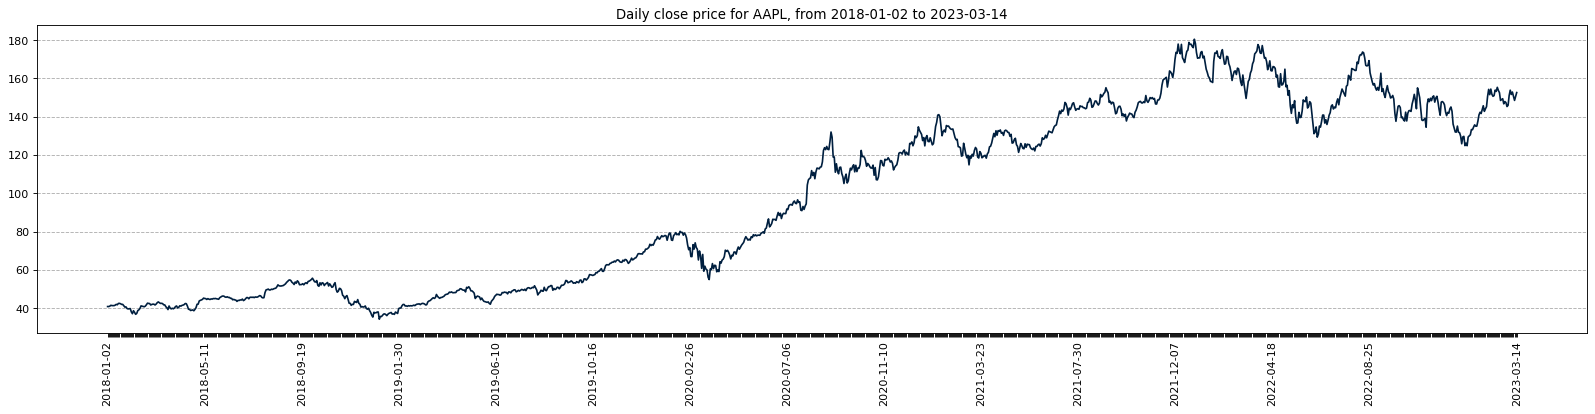

In [24]:
def download_data(config, plot=False):
    # get the data from alpha vantage
    
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    # Return daily adjusted (date, daily open, daily high, daily low, 
    # daily close, daily split/dividend-adjusted close, daily volume) 
    # time series in two json objects as data and meta_data.
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])
    # data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"], )

    state_date = "2018-01-01"
    # keys from data's dict keys
    data_date = [date for date in data.keys() if date >= state_date]
    # data_date = [date for date in data.keys()]
    # get adjust_close prices
    # data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data_date]
    data_close_price.reverse()
    # now from earliest to latest
    data_date.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))

        # Plot the date as x, adjust close price as y
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        
        # xTicks makes dates displayed better
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        # Chart title
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

## Data preparation: normalizing raw financial data

In [25]:
""" This normalization method is called "standard normalization" or "Z-score normalization",
which scales the input data to have a mean of 0 and a standard deviation of 1. 
It is achieved by subtracting the mean from each data point and then dividing by the standard deviation. 
"""
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None
    # fit_transform: Takes a numpy array as input, 
    # calculates the mean (mu) and standard deviation (sd) of each column of the array, 
    # normalizes the array using the mean and standard deviation, and returns the normalized array.

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x
    # inverse_transform: Takes a numpy array as input, uses the mean (mu) and standard deviation (sd) 
    # that were previously calculated in fit_transform to inverse transform the normalized array 
    # back to the original scale, and returns the inverse transformed array.
    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
# scaler = Normalizer()
# normalized_data_close_price = scaler.fit_transform(data_close_price)
# from sklearn.preprocessing import MinMaxScaler #2
# from sklearn.preprocessing import RobustScaler 
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import QuantileTransformer
scaler = MaxAbsScaler()
print(data_close_price.shape)
data_close_price = data_close_price.reshape(-1, 1)
normalized_data_close_price = scaler.fit_transform(data_close_price)
normalized_data_close_price = np.array(normalized_data_close_price)
normalized_data_close_price = normalized_data_close_price.flatten()
print(normalized_data_close_price)
print(normalized_data_close_price.shape)

(1308,)
[0.22628581 0.2262464  0.22729731 ... 0.8229137  0.83383047 0.84557846]
(1308,)


## Data preparation: generating training and validation datasets

C:\Users\nhanb\AppData\Local\Temp\ipykernel_11120\29912055.py:111: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


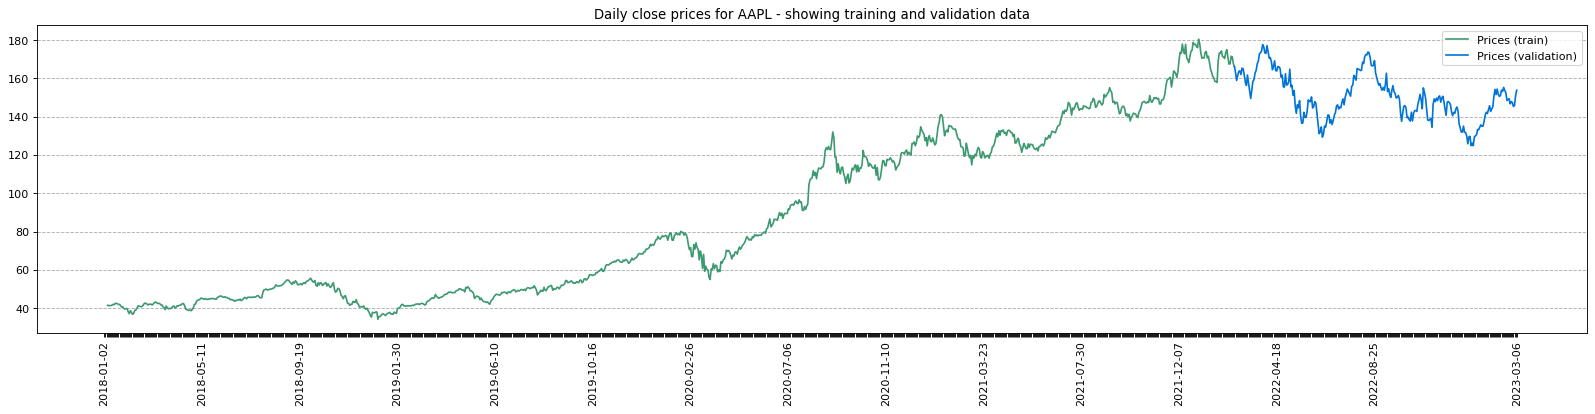

In [26]:

def prepare_data_x(x, window_size):
    '''
    x: 1D arr, window_size: int
    Note: len(x) > window_size
    window_size: the size of the sliding window
    n_row: the number of rows in the windowed data. Can take it by func below.
    output return view of x with the shape is (n_row,window_size) and the strides equal to (x.strides[0],x.strides[0])  
    which ensures that the rows of the output are contiguous in memory.
    
    return:
    tuple of 2 array
    output[:-1]: has shape (n_row, window_size)
    output[-1]: has shape (window_size,) and contains the last window of x.
    '''

    output_size = config["model"]["output_dates"]
    # perform windowing
    # Get all rows execept the last one for tesing
    n_row = x.shape[0] - window_size + 1
    unseen_row = x.shape[0] - window_size - output_size + 1
    # Example: window_size = 20, x with shape = (100, 20) -> n_row = 100 - 20 + 1 = 81
    # output shape = (81, 20), strides = (8, 8)
    # -> output will move up one by one until the 100th element(last element) from the original x,
    # each row of output will have 20 elements
    #   x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # output = array([[1, 2, 3, 4],
    #                 [2, 3, 4, 5],
    #                 [3, 4, 5, 6],
    #                 [4, 5, 6, 7],
    #                 [5, 6, 7, 8],
    #                 [6, 7, 8, 9],
    #                 [7, 8, 9, 10]])
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides = (x.strides[0], x.strides[0]))

    #return (all the element but the last one, return the last element)
    return output[:unseen_row],  output[unseen_row:]

def prepare_data_y(num_rows, x, window_size):
    # output = x[window_size:]
    output_size = config["model"]["output_dates"]
    # X has 10 datapoints, y is the label start from the windowsize 3 with output dates of 3
    # Then x will have 6 rows, 4 usable row
    # x: 0, 1, 2 || 1, 2, 3 || 2, 3, 4 || 3, 4, 5 || 4, 5, 6 || 6, 7, 8 || 7, 8, 9  
    # y: 3, 4, 5 || 4, 5, 6 || 5, 6, 7 || 6, 7, 8 || 7, 8, 9

    # X has 10 datapoints, y is the label start from the windowsize 4 with output dates of 3
    # Then x will have 6 rows, 4 usable row
    # x: 0, 1, 2, 3 || 1, 2, 3, 4 || 2, 3, 4, 5 || 3, 4, 5, 6 || 4, 5, 6, 7 || 5, 6, 7, 8 || 6, 7, 8, 9
    # y: 4, 5, 6    || 5, 6, 7    || 6, 7, 8    || 7, 8, 9    || 8, 9
        
    # Create empty array to hold reshaped array
    output = np.empty((num_rows, output_size))
    # Iterate over original array and extract windows of size 3
    for i in range(num_rows):
        output[i] = x[window_size+i:window_size+i+output_size]
    return output

def prepare_plot_data_y(x, window_size, output_size):
    output = x[window_size: (-output_size + 1) ]
    return output
def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(data_x.shape[0], normalized_data_close_price, window_size=config["data"]["window_size"])
    plot_data_y = prepare_plot_data_y(normalized_data_close_price, window_size=config["data"]["window_size"], output_size = config["model"]["output_dates"])
    
    # split dataset
    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    # from 0 - 80%
    data_x_train = data_x[:split_index]
    # from 80% - 100%
    data_x_val = data_x[split_index:]
    # from 0 - 80%
    data_y_train = data_y[:split_index]
    # from 80% - 100%
    data_y_val = data_y[split_index:]

    # from 0 - 80%
    plot_data_y_train = plot_data_y[:split_index]
    # from 80% - 100%
    plot_data_y_val = plot_data_y[split_index:]
    if plot:

        # prepare data for plotting
        plot_num_data_points = num_data_points - data_x_unseen.shape[0] + 1
        plot_data_date = data_date[:-data_x_unseen.shape[0] + 1]
        to_plot_data_y_train = np.zeros(plot_num_data_points)
        to_plot_data_y_val = np.zeros(plot_num_data_points)

        # inverse to real value
        to_plot_data_y_train = to_plot_data_y_train.reshape(-1,1)
        temp_plot_data_y_train = plot_data_y_train.reshape(-1,1)
        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(temp_plot_data_y_train)
        to_plot_data_y_val = to_plot_data_y_val.reshape(-1,1)
        temp_plot_data_y_val = plot_data_y_val.reshape(-1,1)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(temp_plot_data_y_val)
        to_plot_data_y_val[split_index+config["data"]["window_size"] - 1] = to_plot_data_y_train[split_index+config["data"]["window_size"] - 1]
        # replace 0 with none value
        to_plot_data_y_train = np.where(to_plot_data_y_train == 0.0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0.0, None, to_plot_data_y_val)

        ## plots the historical data followed the validation data

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(plot_data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(plot_data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [plot_data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (plot_num_data_points-i) > config["plots"]["xticks_interval"]) or i==plot_num_data_points-1) else None for i in range(plot_num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, plot_data_y_train, plot_data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, plot_data_y_train, plot_data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=True)

For example, given the input like this:
[
    [a1, b1, c1, d1],
    [a2, b2, c2, d2],
    [a3, b3, c3, d3],
    [a4, b4, c4, d4],
    [a5, b5, c5, d5],
    [a6, b6, c6, d6],
    [a7, b7, c7, d7],
    [a8, b8, c8, c8],
    [a9, b9, c9, d9],
    [a10, b10, c10, d10]
]
The out put should be like this:
[
    [[a1, b1, c1, d1],
    [a2, b2, c2, d2],
    [a3, b3, c3, d3],
    [a4, b4, c4, d4]],

    [[a2, b2, c2, d2],
    [a3, b3, c3, d3],
    [a4, b4, c4, d4],
    [a5, b5, c5, d5]],

    [[a3, b3, c3, d3],
    [a4, b4, c4, d4],
    [a5, b5, c5, d5],
    [a6, b6, c6, d6]],

    [[a4, b4, c4, d4],
    [a5, b5, c5, d5],
    [a6, b6, c6, d6],
    [a7, b7, c7, d7]],

    [[a5, b5, c5, d5],
    [a6, b6, c6, d6],
    [a7, b7, c7, d7],
    [a8, b8, c8, c8]],

    [[a6, b6, c6, d6],
    [a7, b7, c7, d7],
    [a8, b8, c8, c8],
    [a9, b9, c9, d9]],

    [[a7, b7, c7, d7],
    [a8, b8, c8, c8],
    [a9, b9, c9, d9],
    [a10, b10, c10, d10]]
]

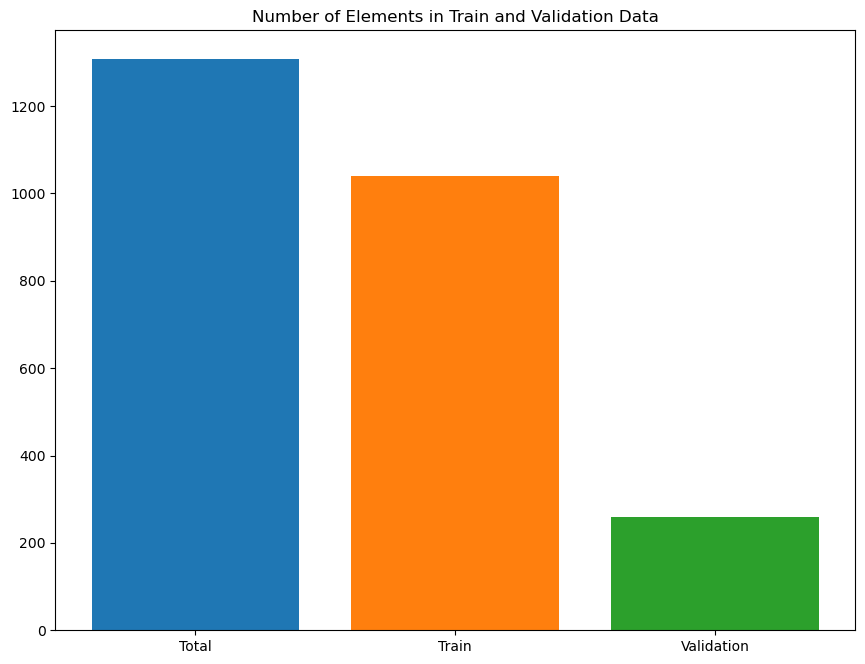

In [27]:
import matplotlib.pyplot as plt

# Get the number of elements in train and validation data
num_train = len(data_x_train)
num_val = len(data_x_val)

# Specify colors and notations for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
notations = ['Total', 'Train', 'Validation']

# Plot the numbers as a bar chart
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(notations, [num_data_points, num_train, num_val], color=colors, tick_label=notations)
ax.set_title('Number of Elements in Train and Validation Data')

plt.show()


In [28]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        # [batch, num of dates, close-price]
        x = np.expand_dims(x, 2) 
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape x:", dataset_train.x.shape, ", y:", dataset_train.y.shape)
print("Validation data shape x:", dataset_val.x.shape, ", y:", dataset_val.y.shape)

Train data shape x: (1039, 3, 1) , y: (1039, 7)
Validation data shape x: (260, 3, 1) , y: (260, 7)


## Defining the LSTM model

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, input_sequences = config["data"]["window_size"] , hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        # input_size: number of feature columns
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        # (Batch, 1) -> 32
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(20)
        """
        hidden_layer_size: the number of output features in the LSTM layer.
        hidden_size: this is the same as hidden_layer_size, and it is used for backward compatibility with older versions of PyTorch.
        batch_first: a boolean indicating whether the first dimension of the input and output tensors should 
        represent the batch size or the sequence length. 
        If batch_first=True,
        then the input and output tensors have shape (batch_size, sequence_length, input_size) and 
        (batch_size, sequence_length, hidden_layer_size), respectively. 
        If batch_first=False, 
        then the input and output tensors have shape (sequence_length, batch_size, input_size) 
        and (sequence_length, batch_size, hidden_layer_size), respectively.
        """
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.bn2 = nn.BatchNorm1d(20)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(input_sequences * hidden_layer_size , output_size)
        self.bn3 = nn.BatchNorm1d(output_size)
        self.init_weights()

    """ The method loops through the named parameters of the lstm layer (nn.LSTM class.)
        The named_parameters() method returns an iterator over the named parameters of the layer, 
        which includes the weights and biases of each LSTM layer.

    """
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            """
            If the name contains the substring 'bias', the bias term is initialized with a constant value of 0 
            using the nn.init.constant_() method.
            """
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
                 
            # If the name contains the substring weight_ih,
            # the input-to-hidden weights are initialized with a Kaiming normal distribution using the nn.init.kaiming_normal_() method.
            # KAIMING_NORMAL: the weights of a neural network are initialized with a Gaussian distribution with mean 0 
            # and standard deviation =  sqrt(2/n), where n is the number of inputs to the layer.
            # This method was specifically designed to work well with activation functions that use rectified linear units (ReLUs),
            # which are commonly used in deep learning models.
            # The Kaiming normal distribution is preferred over other initialization methods, such as random or uniform initialization,
            # because it helps to avoid the vanishing or exploding gradient problem,
            # which can occur when gradients become too small or too large during training, respectively.
            # By properly initializing the weights with a distribution that takes into account the number of inputs,
            # the Kaiming initialization method helps to ensure that the gradients remain stable during training,
            # leading to faster and more stable convergence.

            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)

            # If the name contains the substring weight_hh,
            # the hidden-to-hidden weights are initialized with an orthogonal matrix using the nn.init.orthogonal_() method.
            # A square matrix with real numbers or elements is said to be an orthogonal matrix if its transpose is equal to its inverse matrix.
            # Or we can say when the product of a square matrix and its transpose gives an identity matrix, 
            # then the square matrix is known as an orthogonal matrix.
            # A * A^T = I or AT = A-1
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

        
        # "model": {
        #     "input_size": 1, # since we are only using 1 feature, close price
        #     "num_lstm_layers": 2,
        #     "lstm_size": 32,
        #     "dropout": 0.2,
        # }
    def forward(self, x):

        batchsize = x.shape[0]
        x = self.linear_1(x)
        # x = self.bn1(x)
        x = self.relu(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # x = self.bn2(lstm_out)
        # reshape output from hidden cell into [batch, features] for `linear_2`
        # x = x.permute(1, 0, 2).reshape(batchsize, -1)  
        x = self.dropout(lstm_out)
        x = x.reshape(batchsize, -1)
        # x = self.bn3(x)
        predictions = self.linear_2(x)
        # predictions = self.bn3(predictions)
        return predictions

model = LSTMModel(
    input_size = config["model"]["input_size"], 
    input_sequences = config["data"]["window_size"],
    hidden_layer_size = config["model"]["lstm_size"], 
    num_layers = config["model"]["num_lstm_layers"], 
    output_size = config["model"]["output_dates"],
    dropout = config["model"]["dropout"]
    )
model = model.to(config["training"]["device"])
test_X = torch.rand(config["training"]["batch_size"],  config["data"]["window_size"], config["model"]["input_size"]).to("cuda")
# from torchviz import make_dot
# dot = make_dot(model(test_X), params=dict(model.named_parameters()))
# dot.render("model_graph", format="png")

Early Stop

In [30]:
# return boolen Stop, patient_count, best_loss, current_loss
def early_stop(best_loss, current_loss, patient_count, max_patient):
    if patient_count >= max_patient:
        return True, patient_count, best_loss, current_loss
    else:
        if(best_loss > current_loss):
            best_loss = current_loss
            patient_count = 0
            return False, patient_count, current_loss, current_loss
        else:
            patient_count = patient_count + 1
            return False, patient_count, best_loss, current_loss


Save best model

In [31]:
def save_best_model(model, num_epochs, optimizer, val_loss, training_loss, learning_rate):
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'valid_loss': val_loss,
        'training_loss': training_loss,
        'learning_rate': learning_rate
    }, "best_model")
    
def check_best_loss(best_loss, loss):
    if loss < best_loss:
        return True
    return False

## Model training

In [32]:
import torch
from torch.utils.data import DataLoader, ConcatDataset

def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()

"""
betas: Adam optimizer uses exponentially decaying averages of past gradients to update the parameters.
betas is a tuple of two values that control the decay rates for these moving averages.
The first value (default 0.9) controls the decay rate for the moving average of gradients,
and the second value (default 0.999) controls the decay rate for the moving average of squared gradients.
Higher values of beta will result in a smoother update trajectory and may help to avoid oscillations in the optimization process, 
but may also lead to slower convergence.
eps: eps is a small constant added to the denominator of the Adam update formula to avoid division by zero.
It is typically set to a very small value (e.g. 1e-8 or 1e-9) to ensure numerical stability.
"""
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)

"""
For example, suppose step_size=10 and gamma=0.1.
This means that the learning rate will be multiplied by 0.1 every 10 epochs.
If the initial learning rate is 0.1, then the learning rate will be reduced to 0.01 after 10 epochs, 0.001 after 20 epochs, and so on.
"""

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.01)
loss_train_history = []
loss_val_history = []
lr_train_history = []
lr_val_history = []

best_loss = sys.float_info.max
stop = False
patient = config["training"]["patient"]
patient_count = 0
stopped_epoch = 0
# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    loss_train_history.append(loss_train)
    loss_val_history.append(loss_val)
    lr_train_history.append(lr_train)
    lr_val_history.append(lr_val)
    if(check_best_loss(best_loss=best_loss, loss=loss_val)):
        best_loss = loss_val
        save_best_model(model=model, num_epochs=epoch, optimizer=optimizer, val_loss=loss_val_history, training_loss=loss_train_history, learning_rate=lr_train)
    else:
        stop, patient_count, _, _ = early_stop(best_loss=best_loss, current_loss=loss_train, patient_count=patient_count, max_patient=patient)

    print('Epoch[{}/{}] | loss train:{:.6f}, valid:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
    
    print("patient", patient_count)
    if(stop == True):
        print("Early Stopped At Epoch: {}", epoch)
        stopped_epoch = patient_count
        break
    

Epoch[1/10000] | loss train:0.018241, valid:0.001377 | lr:0.010000
patient 0
Epoch[2/10000] | loss train:0.002888, valid:0.000919 | lr:0.010000
patient 0
Epoch[3/10000] | loss train:0.001427, valid:0.001303 | lr:0.010000
patient 1
Epoch[4/10000] | loss train:0.001090, valid:0.001600 | lr:0.010000
patient 2
Epoch[5/10000] | loss train:0.001023, valid:0.000244 | lr:0.010000
patient 2
Epoch[6/10000] | loss train:0.000838, valid:0.000537 | lr:0.010000
patient 3
Epoch[7/10000] | loss train:0.001031, valid:0.000970 | lr:0.010000
patient 4
Epoch[8/10000] | loss train:0.000752, valid:0.002603 | lr:0.010000
patient 5
Epoch[9/10000] | loss train:0.000959, valid:0.000380 | lr:0.010000
patient 6
Epoch[10/10000] | loss train:0.000670, valid:0.000636 | lr:0.010000
patient 7
Epoch[11/10000] | loss train:0.000534, valid:0.000667 | lr:0.010000
patient 8
Epoch[12/10000] | loss train:0.000560, valid:0.000820 | lr:0.010000
patient 9
Epoch[13/10000] | loss train:0.000552, valid:0.000314 | lr:0.010000
patie

Load the state

In [33]:
# load the saved model weights from a file
checkpoint = torch.load('best_model')
model.load_state_dict(checkpoint['model_state_dict'])
print("Epoch: ", checkpoint["epoch"], "Valid loss: ", checkpoint["valid_loss"], "Training loss: ", checkpoint["training_loss"])

Epoch:  173 Valid loss:  [0.0013774563267361373, 0.0009192394554702332, 0.0013027668101130985, 0.0015996680995158385, 0.00024435226623609196, 0.0005369515693018911, 0.000969529697613325, 0.0026029373693745583, 0.0003800658705586102, 0.0006356190297083231, 0.00066687948674371, 0.0008196832022804301, 0.000313574955725926, 0.00028595493313332554, 0.00020691213831014466, 0.0003681500784296077, 0.001232688280651928, 0.0002650190181157086, 0.000661665255393018, 0.0004372683179099113, 0.00033497335607535206, 0.001554160102386959, 0.0007418286186293699, 0.0004151250068389345, 0.0010525918933126377, 0.0007895196049503284, 0.0016394208287238143, 0.0004644361997634405, 0.0004834032315557124, 0.00020190072973491624, 0.00048693733333493583, 0.0004898575898550916, 0.0010329011056455784, 0.0011434207845013589, 0.00033663015710772015, 0.00035362074777367525, 0.0005997526150167687, 0.00026382234318589326, 0.0006646406072832178, 0.0007320074109884445, 0.0004906440317427041, 0.0004404936435093987, 0.0005

Plotting loss vs epoch

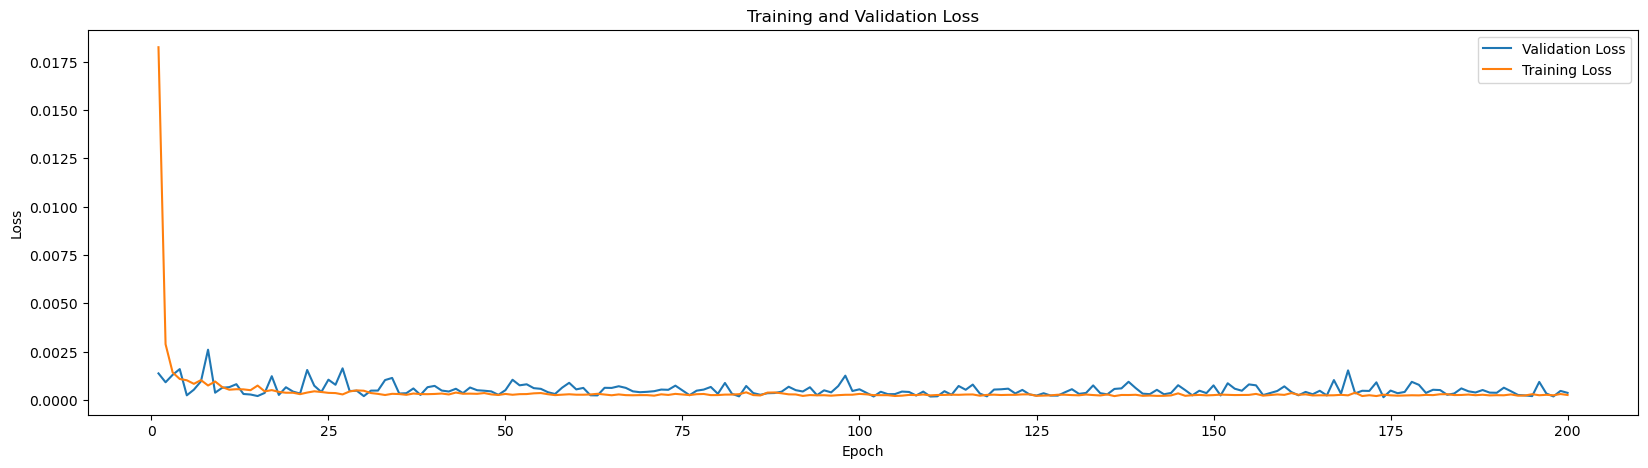

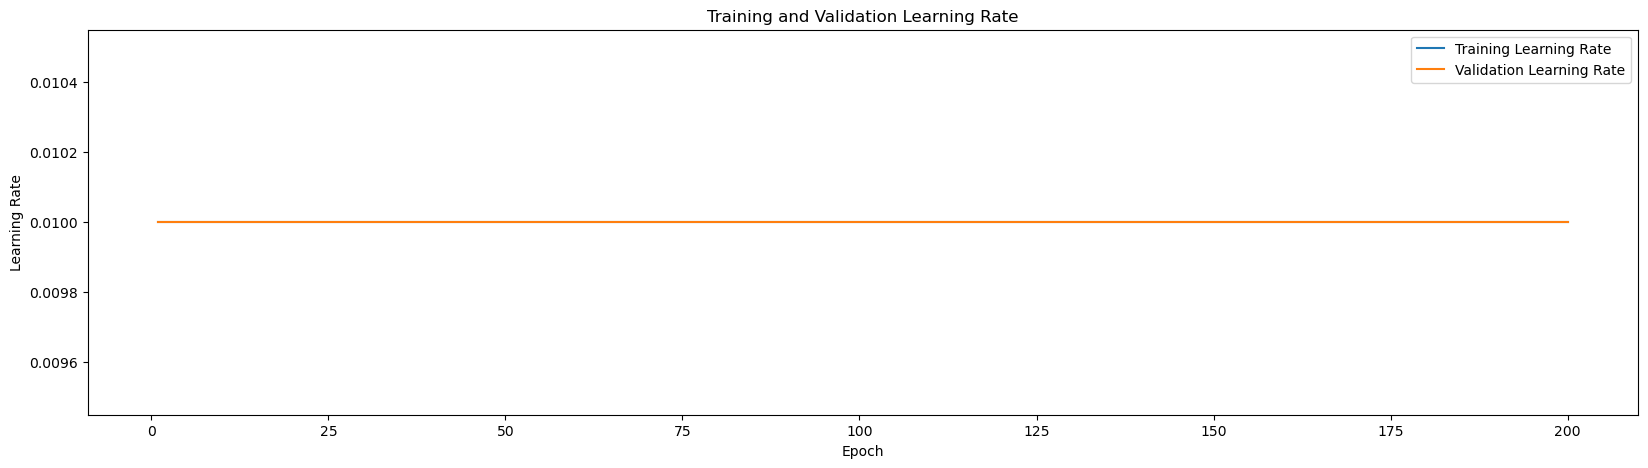

In [34]:
import matplotlib.pyplot as plt

if stopped_epoch == 0:
    # your arrays
    plot_epoch = range(1, (config["training"]["num_epoch"] + 1))
    fig = plt.figure(figsize=(20, 5))
    # plot the loss
    plt.plot(plot_epoch, loss_val_history, label='Validation Loss')
    plt.plot(plot_epoch, loss_train_history, label='Training Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the learning rate
    fig = plt.figure(figsize=(20, 5))
    plt.plot(plot_epoch, lr_train_history, label='Training Learning Rate')
    plt.plot(plot_epoch, lr_val_history, label='Validation Learning Rate')
    plt.title('Training and Validation Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()
else:
    # your arrays
    plot_epoch = range(1, stopped_epoch + 1)
    fig = plt.figure(figsize=(20, 5))
    # plot the loss
    plt.plot(plot_epoch, loss_val_history[:stopped_epoch], label='Validation Loss')
    plt.plot(plot_epoch, loss_train_history[:stopped_epoch], label='Training Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the learning rate
    fig = plt.figure(figsize=(20, 5))
    plt.plot(plot_epoch, lr_train_history[:stopped_epoch], label='Training Learning Rate')
    plt.plot(plot_epoch, lr_val_history[:stopped_epoch], label='Validation Learning Rate')
    plt.title('Training and Validation Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()   

## Model evaluation

In [35]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)
model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.empty((0, config["model"]["output_dates"]))

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.empty((0, config["model"]["output_dates"]))

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# batch size of each iteration
# val_loss = average loss of each batch

criterion2 = nn.L1Loss()
criterion3 = nn.NLLLoss()
def evaluate(val_dataloader, model, is_training=False):
    MSE_val_loss = 0
    MAE_val_loss = 0
    RMSE_val_loss = 0
    y_true = []
    y_pred = []
    model.eval()

    for idx, (x, y) in enumerate(val_dataloader):

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])
        y_true.append(y)

        out = model(x)
        y_pred.append(out)

        # y = torch.tensor(y).to("cuda")
        # out = torch.tensor(out).to("cuda")
        loss = criterion(out.contiguous(), y.contiguous())
        loss2 = criterion2(out.contiguous(), y.contiguous())
        loss3 = torch.sqrt(loss)
        # loss3 = criterion3(out.contiguous(), y.contiguous())
        if is_training:
            loss.backward()
            optimizer.step()

        # val_loss += (loss.deta`ch().item() / batchsize)
        MSE_val_loss += loss.detach().item()
        MAE_val_loss += loss2.detach().item()
        RMSE_val_loss += loss3.detach().item()
        
    return MSE_val_loss, MAE_val_loss, RMSE_val_loss, y_true, y_pred
MSE_val_loss, MAE_val_loss, RMSE_val_loss, y_true,  y_pred = evaluate(val_dataloader=val_dataloader, model=model)

print('MSE Valid loss:{:.6f}%, MAE Valid loss:{:.6f}%, RMSE Valid loss:{:.6f}%'
                .format(MSE_val_loss * 100 / (len(val_dataloader) * config["training"]["batch_size"]), 
                        MAE_val_loss * 100 / (len(val_dataloader) * config["training"]["batch_size"]),
                        RMSE_val_loss * 100 / (len(val_dataloader) * config["training"]["batch_size"])))
print('MSE Valid loss:{:.6f}, MAE Valid loss:{:.6f}, RMSE Valid loss:{:.6f}'
                .format(MSE_val_loss, 
                        MAE_val_loss,
                        RMSE_val_loss))
# print('Valid loss:{:.6f}%'
#                 .format(val_loss))

MSE Valid loss:0.001685%, MAE Valid loss:0.041561%, RMSE Valid loss:0.050849%
MSE Valid loss:0.005393, MAE Valid loss:0.132996, RMSE Valid loss:0.162718


In [36]:
def rmse_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2))

In [37]:
def spread_out_prediction(prediction, sequences, max_lenght, num_data_points):
    # size of the array calculated by formula:
    # num_data_points - sequences + 1
    flat_list = np.zeros((max_lenght))

    for i in range( 0, num_data_points):
        flat_list[i] = prediction[i][1]
        
    return flat_list


In [38]:
def reverse_spread_out_prediction(prediction, sequences, max_lenght, num_data_points):
    # size of the array calculated by formula:
    # num_data_points - sequences + 1
    flat_list = np.zeros((max_lenght))
    flat_list[-sequences:] = prediction[0][:sequences]

    for i in range( 0, num_data_points - sequences):
        flat_list[i + sequences] = prediction[i + 1][-1]
        
    return flat_list

In [39]:
def add_zero(prediction, max_lenght):
    while(len(prediction < max_lenght)):
        np.concatenate(prediction, [0])
    return prediction

## Predicting future stock prices

C:\Users\nhanb\AppData\Local\Temp\ipykernel_11120\823208046.py:51: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


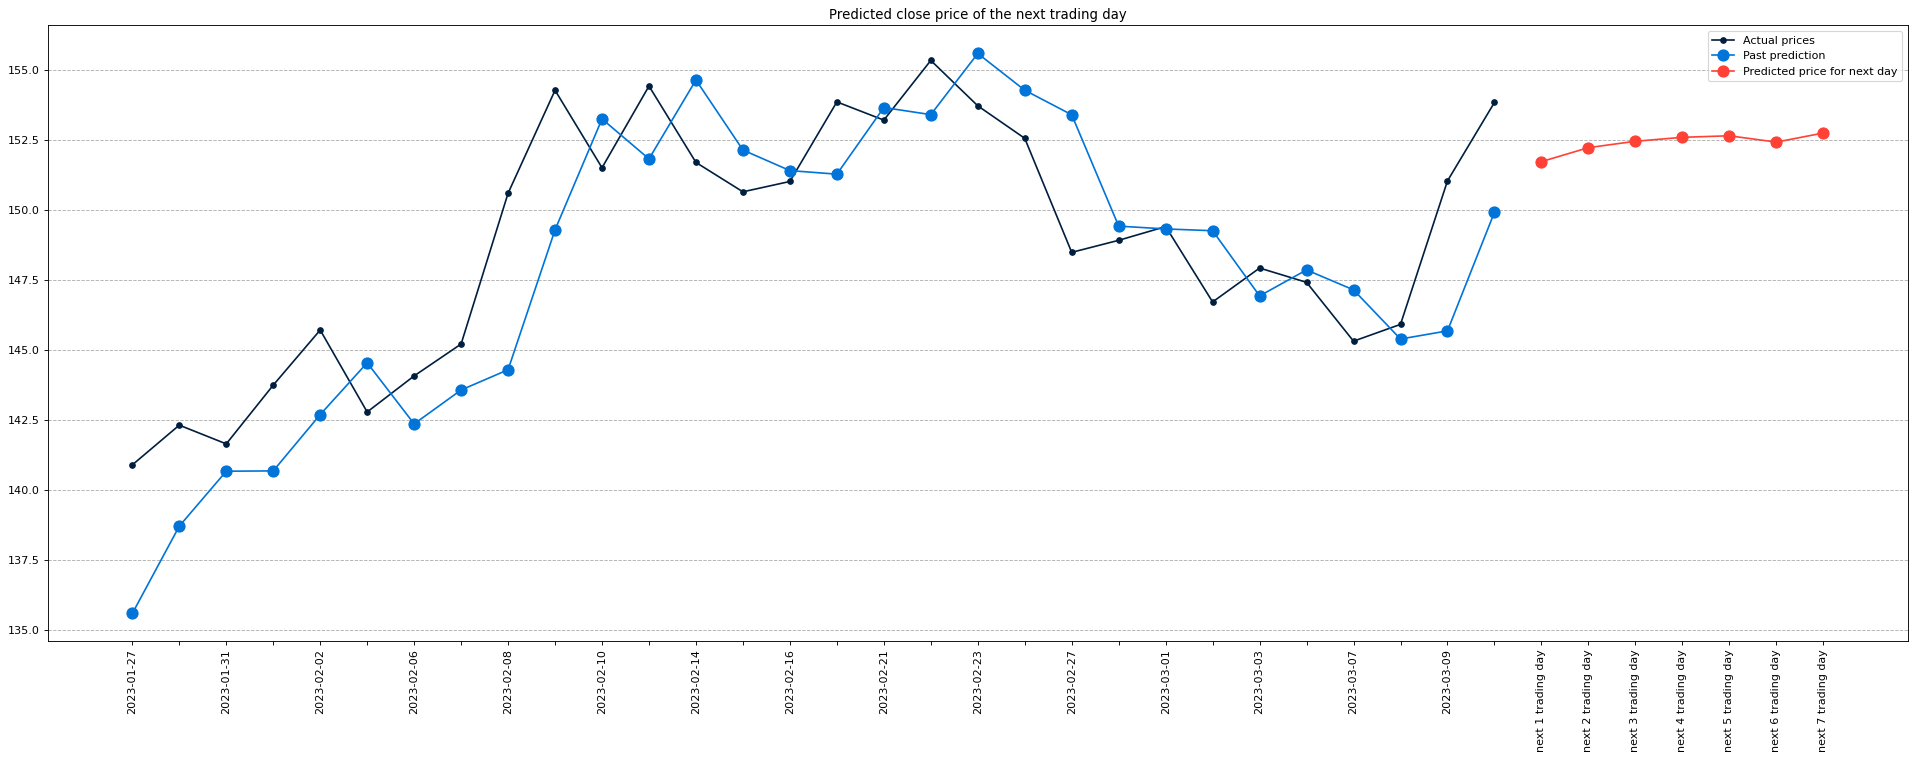

Predicted close price of the next trading day:
[151.71751 152.21684 152.44458 152.58568 152.6407  152.41484 152.73875]


In [40]:
# predict on the unseen data, tomorrow's price 

model.eval()
# x = torch.tensor(data_x_unseen).float().to(config["training"]["device"])
x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)
num_plot = prediction.shape[0]

if config["plots"]["show_plots"]:
    plot_range = 30
    test_size = data_x_unseen.shape[0]
    plot_num_data_points = num_data_points - test_size + 1
    plot_data_date = data_date[:-2]

    plot_date_test = plot_data_date[-plot_range:]
    for i in range(test_size):
        plot_date_test.append("next {} trading day".format(i+1))

    # Real 30 days
    to_plot_y_true = np.zeros((plot_range + test_size, 1))
    temp_plot_data_y_val = plot_data_y_val.reshape(-1,1)
    to_plot_y_true[:plot_range] = scaler.inverse_transform(temp_plot_data_y_val)[-plot_range:]
    # Prediction last 27 days
    to_plot_y_pred = np.zeros((plot_range + test_size, config["model"]["output_dates"]))
    to_plot_y_pred[:plot_range] = scaler.inverse_transform(predicted_val)[-plot_range:]
    # Compute the row-wise mean of the original array
    to_plot_y_pred = spread_out_prediction(to_plot_y_pred, sequences = 3, max_lenght = plot_range + test_size, num_data_points = plot_range)
    # prediction = np.mean(prediction, axis=1)

    to_plot_test = np.zeros(plot_range + test_size)
    to_plot_test[plot_range:] = prediction[-1]

    to_plot_test = np.where(to_plot_test == 0, None, to_plot_test)
    to_plot_y_true = np.where(to_plot_y_true == 0, None, to_plot_y_true)
    to_plot_y_pred = np.where(to_plot_y_pred == 0, None, to_plot_y_pred)
    # plot

    fig = figure(figsize=(30, 10), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_y_true, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_y_pred, label="Past prediction", marker=".", markersize=20, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_test, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    
    xticks = [plot_date_test[i] if ((i%2 == 0 and (plot_range + test_size - i ) > 2) or i > plot_range)  else None for i in range(plot_range + test_size )] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')

    plt.title("Predicted close price of the next trading day")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:")
print(prediction[-1])

